In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/Colab Notebooks/13 - NLP/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/13 - NLP


In [ ]:
%%capture
!pip install transformers
!pip install tensorflow_addons

In [ ]:
# !curl -LO https://raw.githubusercontent.com/MohamadMerchant/SNLI/master/data.tar.gz
# !tar -xvzf data.tar.gz

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import transformers
from sklearn.manifold import TSNE
from tensorflow.keras.utils import plot_model
import logging
logging.getLogger('tensorflow').disabled = True
pd.set_option('max_colwidth', 400)

In [ ]:
# Define the strategy to use and print the number of devices found
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [ ]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))
# strategy = tf.distribute.TPUStrategy(resolver)

# Text Classification

## Data Import

In [ ]:
train_df = pd.read_csv("./data/SNLI_Corpus/snli_1.0_train.csv", nrows=100000)
valid_df = pd.read_csv("./data/SNLI_Corpus/snli_1.0_dev.csv")
test_df = pd.read_csv("./data/SNLI_Corpus/snli_1.0_test.csv")

train_df = train_df[train_df.similarity != "-"].sample(frac=1.0, random_state=42).reset_index(drop=True)
valid_df = valid_df[valid_df.similarity != "-"].sample(frac=1.0, random_state=42).reset_index(drop=True)
train_df.head()

,similarity,sentence1,sentence2
0,contradiction,A woman is using toy which blows giant bubbles.,A little girl is playing with chalk on a driveway.
1,neutral,A young Asian girl holds a stuffed cat toy in a classroom.,"A young Asian girl sits in class with a stuffed cat toy, the only surviving possession remaining after the tsunami."
2,entailment,A young woman with an afro and an electronic device in her hands walks next to an orange bike.,A young woman walks next to an orange bike.
3,neutral,A young asian girl is sliding down a pole on outdoor playground equipment.,The girl has yellow skin
4,entailment,a man is walking with a cane.,The man is walking.


In [ ]:
# label encoding
label_map = dict(enumerate(train_df['similarity'].astype('category').cat.categories))
y_train = train_df['similarity'].map({v:k for k, v in label_map.items()}).values
y_val = valid_df['similarity'].map({v:k for k, v in label_map.items()}).values
y_test = test_df['similarity'].map({v:k for k, v in label_map.items()}).values

## Pre-processing

In [ ]:
max_length = 64
batch_size = 32

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained( "bert-base-uncased", do_lower_case=True)
print(len(tokenizer.get_vocab()))
tokenizer.encode('Hello Tensorflow')

In [ ]:
sentence_pairs = train_df[["sentence1", "sentence2"]].values[:5]
encoded = tokenizer.batch_encode_plus(
    sentence_pairs.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    return_attention_mask=True,
    return_token_type_ids=True,
    padding='max_length',
    return_tensors="tf")

print(encoded.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [ ]:
print(encoded['input_ids'][0][:32])
print(encoded['token_type_ids'][0][:32])
print(encoded['attention_mask'][0][:32])

tf.Tensor(
[  101  1037  2450  2003  2478  9121  2029 13783  5016 17255  1012   102
  1037  2210  2611  2003  2652  2007 16833  2006  1037 11202  1012   102
     0     0     0     0     0     0     0     0], shape=(32,), dtype=int32)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)
tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)


In [ ]:
tokenizer.decode(encoded['input_ids'][0][:32])

'[CLS] a woman is using toy which blows giant bubbles. [SEP] a little girl is playing with chalk on a driveway. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
class BertDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(self, sentence_pairs, labels, batch_size=batch_size, shuffle=True, include_targets=True):

        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        self.tokenizer = transformers.BertTokenizer.from_pretrained( "bert-base-uncased", do_lower_case=True)
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are, encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            padding='max_length',
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)

## Model Building 

Outputs of Bert Model comprised of:

- ***last_hidden_state*** with shape=(m, seq_len, embed_dim)
- ***pooler_output*** with shape=(m, emb_dim)
- ***hidden_states*** which generate the hidden state for all transformer layers. Only when set *output_hidden_states=True*, shape=(num_layers, m, seq_len, emb_dim)
- ***attentions*** attention weights from each layer.  Only when set *output_attentions=True*, shape=(num_layers, m, seq_len, emb_dim)





In [ ]:
def build_model():

  # Encoded token ids from BERT tokenizer
  input_ids = tf.keras.layers.Input(shape=(max_length, ), dtype=tf.int32, name="input_ids")
  # Attention masks indicates to the model which tokens should be attended to
  attention_masks = tf.keras.layers.Input(shape=(max_length, ), dtype=tf.int32, name="attention_masks")
  # Token type ids are binary masks identifying different sequences in the model
  token_type_ids = tf.keras.layers.Input(shape=(max_length, ), dtype=tf.int32, name="token_type_ids")

  # Loading pretrained BERT model, freeze the weight, check bert_model.config to configure
  bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
  bert_model.trainable = False

  bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids, output_attentions=False, output_hidden_states=False)
  sequence_output = bert_output["last_hidden_state"] # (m, seq_len, emb_dim)
  pooled_output = bert_output["pooler_output"] # (m, emb_dim)

  # Add trainable layers on top of Bert to adapt the pretrained features on the new data.
  bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(2, return_sequences=True))(sequence_output) # (m, emb_dim, hidden_unit * 2)
  
  # Applying hybrid pooling approach to bi_lstm sequence output.
  avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm) # (m, hidden_unit)
  max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm) # (m, hidden_unit)
  concat = tf.keras.layers.concatenate([avg_pool, max_pool]) # (m, hidden_unit)
  dropout = tf.keras.layers.Dropout(0.3)(concat)
  output = tf.keras.layers.Dense(3, activation="softmax")(dropout) #(m, 3)

  model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids], outputs=output)
  return model

In [ ]:
bert_encoder = build_model()
bert_encoder.compile(optimizer=tf.keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics=["acc"])
bert_encoder.summary()

## Model Training (Frozen Pre-trained Bert)

In [ ]:
# generate batch data
train_data = BertDataGenerator(train_df[["sentence1", "sentence2"]].values.astype("str"), y_train, batch_size=batch_size, shuffle=True)
valid_data = BertDataGenerator(valid_df[["sentence1", "sentence2"]].values.astype("str"), y_val, batch_size=batch_size, shuffle=False)

In [ ]:
epochs = 2
history = bert_encoder.fit(train_data, validation_data=valid_data, epochs=epochs, use_multiprocessing=True, workers=-1, steps_per_epoch=10)

## Fine Tuning Bert

This step must only be performed after the feature extraction model has been trained to convergence on the new data.

This is an optional last step where bert_model is unfreezed and retrained with a very low learning rate. This can deliver meaningful improvement by incrementally adapting the pretrained features to the new data.

In [ ]:
bert_encoder.layers[3].trainable = True
# Recompile the model to make the change effective.
bert_encoder.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
bert_encoder.summary()

# train entire model
history = bert_encoder.fit(train_data, validation_data=valid_data, epochs=epochs, use_multiprocessing=True, workers=-1,)

## Evaluation

In [ ]:
test_data = BertDataGenerator(test_df[["sentence1", "sentence2"]].values.astype("str"), y_test, batch_size=batch_size, shuffle=False)
model.evaluate(test_data, verbose=1)

In [ ]:
def check_similarity(sentence1, sentence2):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertDataGenerator(sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False)

    proba = model.predict(test_data)[0]
    idx = np.argmax(proba)
    proba = f"{proba[idx]: .2f}%"
    pred = label_map.get(idx)
    return pred, proba

In [ ]:
sentence1 = "Two women are observing something together."
sentence2 = "Two women are standing with their eyes closed."
check_similarity(sentence1, sentence2)

# Siamese BERT-Networks

## Data Loading

In [ ]:
train_df = pd.read_csv('./data/final_fewshot_train.csv', usecols=['text', 'class'])
test_df = pd.read_csv('./data/final_fewshot_test.csv', usecols=['text', 'class'])
train_df['class'] = train_df['class'].astype('category')
test_df['class'] = test_df['class'].astype('category')
train_df.head()

,text,class
0,[ALLUXIO-2743] Fix failing unit tests,1
1,#2 Refactored structure of Argument,3
2,Remove some features from JwtTokenStore,4
3,Remove duplicated 1.613 section from changelog,2
4,* webapp structure refactoring,3


## Pre-processing

In [ ]:
EMB_DIM = 512
MAX_LEN = 128
BACTH_SIZE = 32

In [ ]:
# creating the necessary datastructures for selcting triplets
unique_train_label = np.array(train_df['class'].unique().tolist())
labels_train = np.array(train_df['class'].tolist())
map_train_label_indices = {label: np.flatnonzero(labels_train == label) for label in unique_train_label}

# define tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained( "bert-base-uncased", do_lower_case=True)

def get_triplets(unique_train_label, map_train_label_indices):
      label_l, label_r = np.random.choice(unique_train_label, 2, replace=False)
      a, p = np.random.choice(map_train_label_indices[label_l], 2, replace=False)
      n = np.random.choice(map_train_label_indices[label_r])
      return a, p, n

def get_triplets_batch(k, train_set, unique_train_label, map_train_label_indices):
    while True:
      idxs_a, idxs_p, idxs_n = [], [], []
      for _ in range(k):
          a, p, n = get_triplets(unique_train_label,map_train_label_indices)
          idxs_a.append(a)
          idxs_p.append(p)
          idxs_n.append(n)

      lis = []
      for idxs in [idxs_a, idxs_p, idxs_n]:

        temp = tokenizer.batch_encode_plus(
            train_set.iloc[idxs].values.tolist(),
            add_special_tokens=True,
            max_length=MAX_LEN,
            return_attention_mask=True,
            return_token_type_ids=True,
            padding='max_length',
            return_tensors="tf"
            )
        
        lis.append(temp)

      # return train_set[idxs_a], train_set[idxs_p], train_set[idxs_n]
      yield [
             lis[0]['input_ids'], 
             lis[0]['attention_mask'], 
             lis[0]['token_type_ids'], 
             lis[1]['input_ids'], 
             lis[1]['attention_mask'], 
             lis[1]['token_type_ids'], 
             lis[2]['input_ids'], 
             lis[2]['attention_mask'], 
             lis[2]['token_type_ids']
             ], []

In [ ]:
 # (2, 9, 32, 128)
data = get_triplets_batch(BACTH_SIZE, train_df['text'], unique_train_label, map_train_label_indices)

## Model Building

In [ ]:
class TripletLossLayer(tf.keras.layers.Layer):
    '''triple loss layers'''
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = tf.reduce_sum(tf.square(a-p), axis=-1)
        n_dist = tf.reduce_sum(tf.square(a-n), axis=-1)
        return tf.reduce_sum(tf.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

@tf.autograph.experimental.do_not_convert
def single_bert(max_length=MAX_LEN):

  # define layers
  bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
  bert_model.trainable = False

  input_ids = tf.keras.layers.Input(shape=(max_length, ), dtype=tf.int32, name="input_ids")
  attention_masks = tf.keras.layers.Input(shape=(max_length, ), dtype=tf.int32, name="attention_masks")
  token_type_ids = tf.keras.layers.Input(shape=(max_length, ), dtype=tf.int32, name="token_type_ids")

  bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids, output_attentions=False, output_hidden_states=False)
  sequence_output = bert_output["last_hidden_state"] # (m, seq_len, emb_dim)
  pooled_output = bert_output["pooler_output"] # (m, emb_dim)

  x = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
  # x = tf.keras.layers.Dropout(0.4)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
  # x = tf.keras.layers.Dropout(0.4)(x)

  dense_layer = tf.keras.layers.Dense(128, name='dense_layer')(x)
  norm_layer = tf.keras.layers.Lambda(lambda  x: tf.nn.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

  model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids], outputs=norm_layer)
  return model

In [ ]:
# siamese network
tf.keras.backend.clear_session()
with strategy.scope():
  encoder = single_bert()

  # anchor
  a_input = tf.keras.layers.Input(shape=(MAX_LEN, ), dtype=tf.int32)
  a_attention = tf.keras.layers.Input(shape=(MAX_LEN, ), dtype=tf.int32)
  a_token = tf.keras.layers.Input(shape=(MAX_LEN, ), dtype=tf.int32)

  # positive
  p_input = tf.keras.layers.Input(shape=(MAX_LEN, ), dtype=tf.int32)
  p_attention = tf.keras.layers.Input(shape=(MAX_LEN, ), dtype=tf.int32)
  p_token = tf.keras.layers.Input(shape=(MAX_LEN, ), dtype=tf.int32)

  # negative
  n_input = tf.keras.layers.Input(shape=(MAX_LEN, ), dtype=tf.int32)
  n_attention = tf.keras.layers.Input(shape=(MAX_LEN, ), dtype=tf.int32)
  n_token = tf.keras.layers.Input(shape=(MAX_LEN, ), dtype=tf.int32)

  # embedding of all inputs
  emb_a = encoder([a_input, a_attention, a_token]) # (m, emb_dim)
  emb_p = encoder([p_input, p_attention, p_token]) # (m, emb_dim)
  emb_n = encoder([n_input, n_attention, n_token]) # (m, emb_dim)

  # triple loss layer
  triplet_loss_layer = TripletLossLayer(alpha=0.4, name='triplet_loss_layer')([emb_a, emb_p, emb_n])
  SNN_model = tf.keras.models.Model([a_input, a_attention, a_token, p_input, p_attention, p_token, n_input, n_attention, n_token], triplet_loss_layer)
  SNN_model.compile(loss=None, optimizer=tf.keras.optimizers.Adam())

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Model Training

In [ ]:
 # (2, 9, 32, 128)
train_data = get_triplets_batch(BACTH_SIZE, train_df['text'], unique_train_label, map_train_label_indices)
SNN_model.fit(train_data, epochs=200, use_multiprocessing=True, workers=-1, steps_per_epoch=30)

Epoch 1/200
30/30 [==============================] - 45s 290ms/step - loss: 12.7427
Epoch 2/200
30/30 [==============================] - 9s 292ms/step - loss: 10.4989
Epoch 3/200
30/30 [==============================] - 9s 292ms/step - loss: 7.9083
Epoch 4/200
30/30 [==============================] - 9s 291ms/step - loss: 6.1191
Epoch 5/200
30/30 [==============================] - 9s 290ms/step - loss: 4.5275
Epoch 6/200
30/30 [==============================] - 9s 292ms/step - loss: 3.6580
Epoch 7/200
30/30 [==============================] - 9s 290ms/step - loss: 3.4999
Epoch 8/200
30/30 [==============================] - 9s 292ms/step - loss: 3.9352
Epoch 9/200
30/30 [==============================] - 9s 294ms/step - loss: 2.7601
Epoch 10/200
30/30 [==============================] - 9s 294ms/step - loss: 2.6659
Epoch 11/200
30/30 [==============================] - 9s 292ms/step - loss: 2.7474
Epoch 12/200
30/30 [==============================] - 9s 294ms/step - loss: 3.5092
Epoch 13/2

## Clustering

In [ ]:
encoded_test = tokenizer.batch_encode_plus(
    test_df['text'].values,
    add_special_tokens=True,
    max_length=MAX_LEN,
    return_attention_mask=True,
    return_token_type_ids=True,
    padding='max_length',
    truncation=True,
    return_tensors="tf"
    )

In [ ]:
X_test = encoder.predict([encoded_test['input_ids'], encoded_test['attention_mask'], encoded_test['token_type_ids']])
y_test = np.array(test_df['class'].values.tolist())

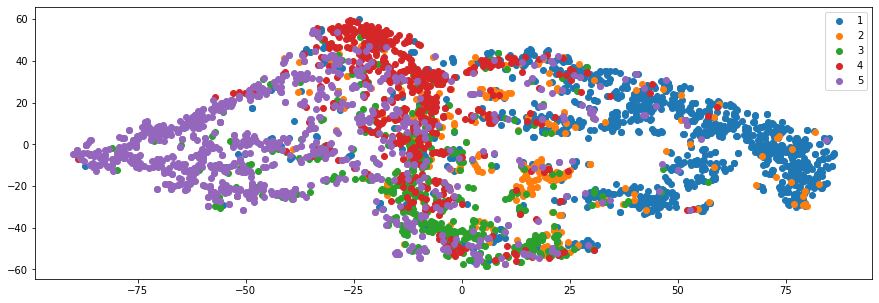

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(X_test)
plt.figure(figsize=(15, 5))

for i, t in enumerate(set(y_test)):
    idx = y_test == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)

plt.legend(bbox_to_anchor=(1, 1));

## Playground

In [ ]:
https://coaxsoft.com/blog/building-bert-with-pytorch-from-scratch

In [ ]:
https://jaketae.github.io/study/gpt/